## Loading the images
First we want to load the images into a numpy array. Before we do that, let's set up some imports and paths.


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage

folder_path = "toyProblem_F22"

## Load into a NumPy array
We then want to store the data in a NumPy array.
Along the way we are tasked to convert to grayscale and normalise to the range [0, 1].

In [6]:
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".png")])

num_frames = len(image_files)
image_shape = (256, 256)
image_sequence = np.zeros((num_frames, *image_shape), dtype=np.float32)

for i, file in enumerate(image_files):
    img_path = os.path.join(folder_path, file)
    img = Image.open(img_path).convert("L") # this converts to grayscale
    img_array = np.array(img, dtype=np.float32) / 255.0 # this normalises to [0, 1]
    image_sequence[i] = img_array

## Showing the images
We then want to show the images. We do this by showing each image and adding a delay of 0.1 seconds, clearing the frame and restarting.

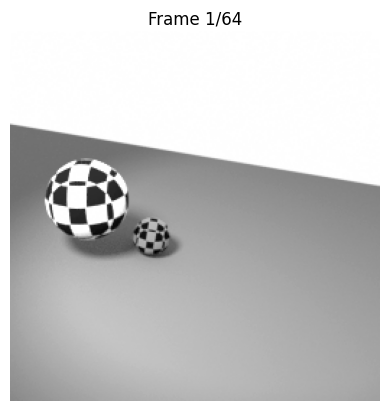

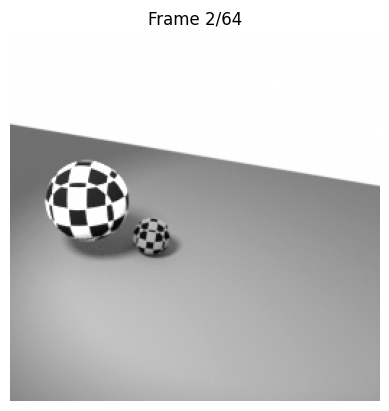

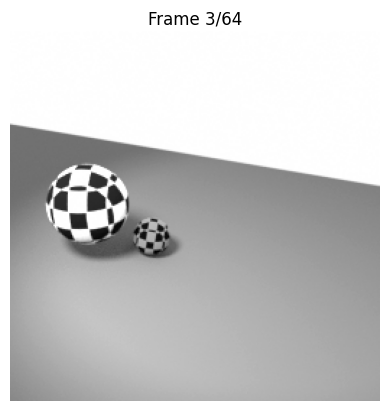

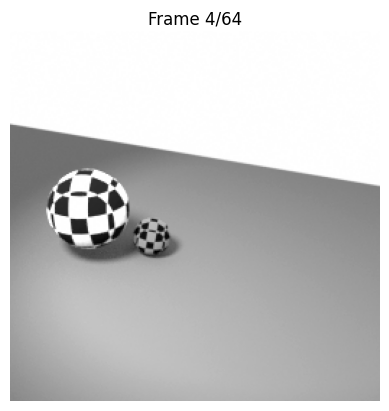

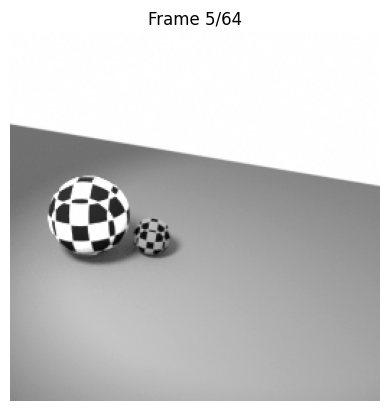

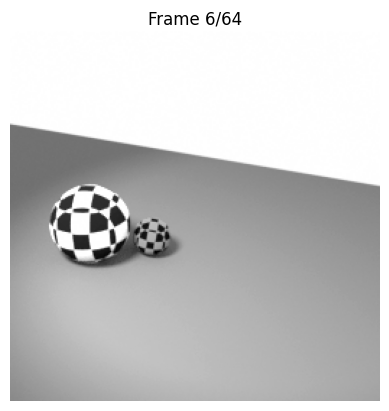

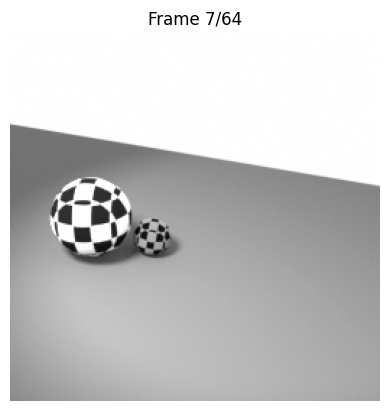

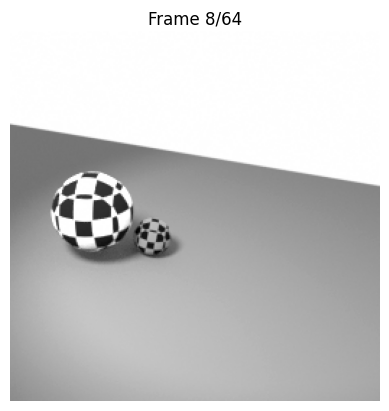

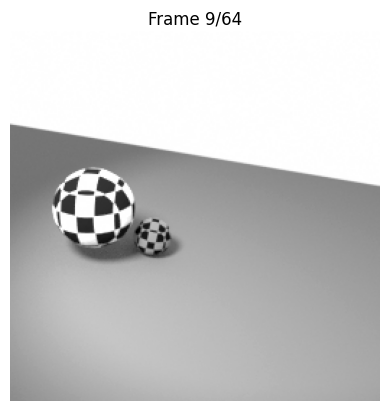

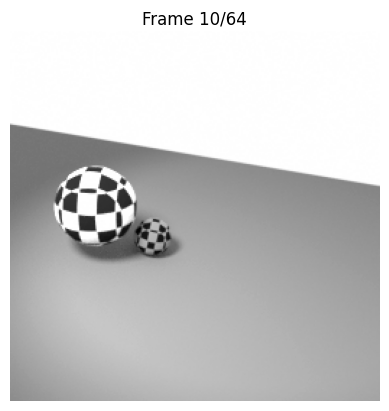

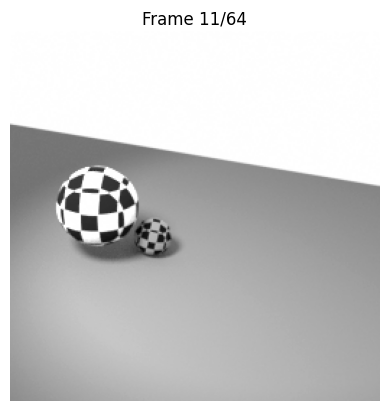

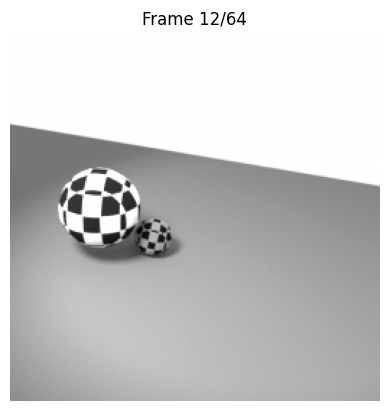

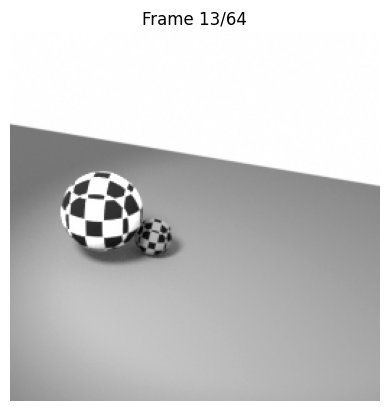

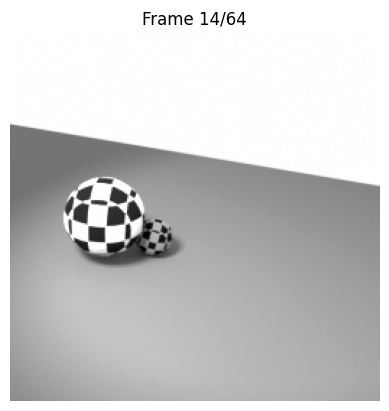

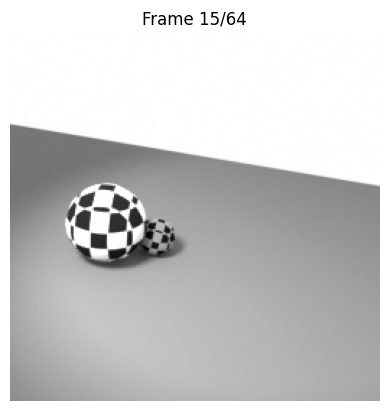

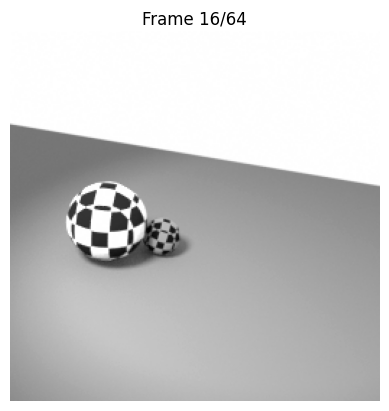

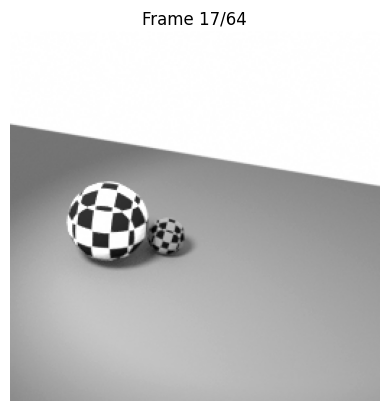

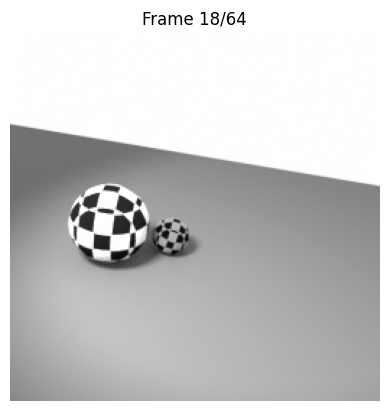

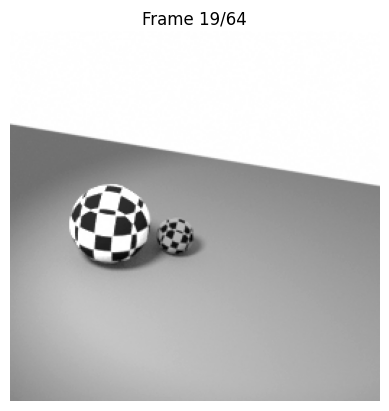

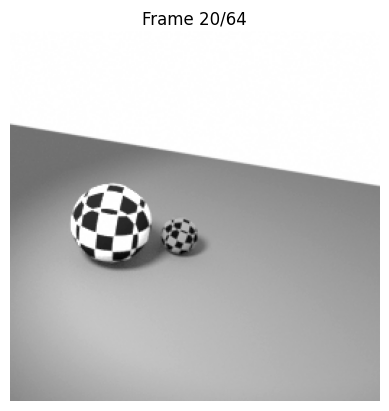

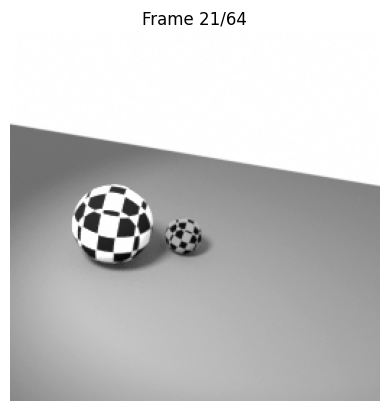

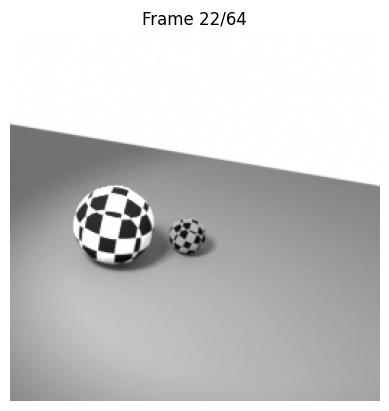

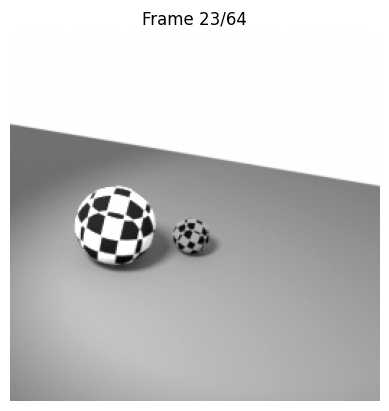

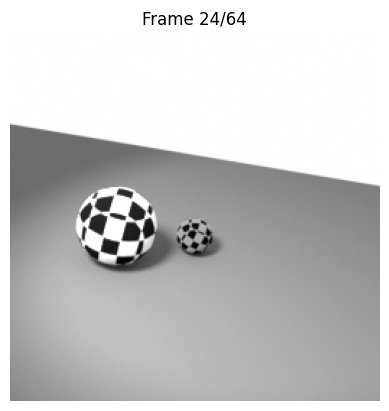

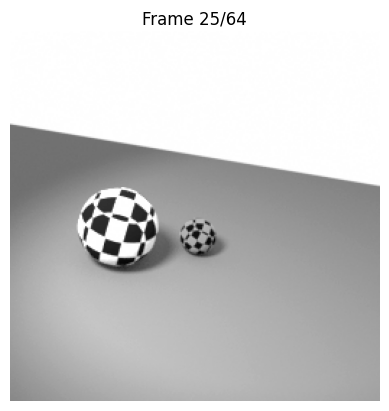

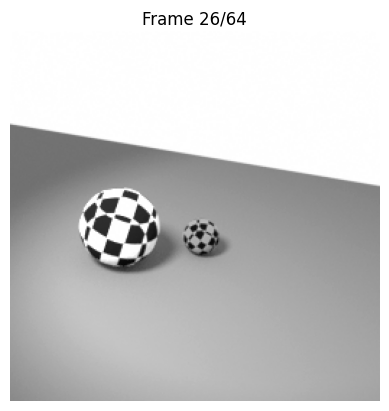

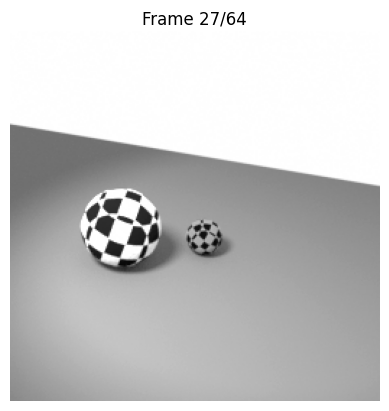

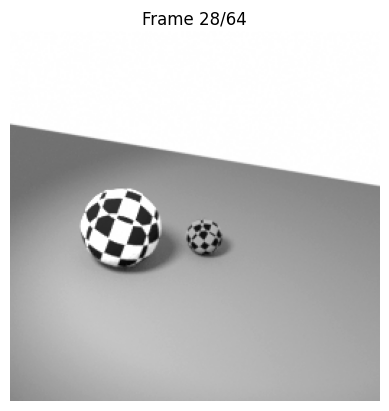

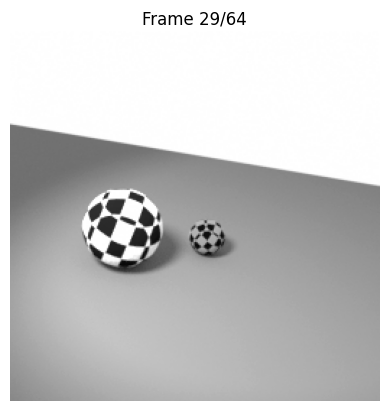

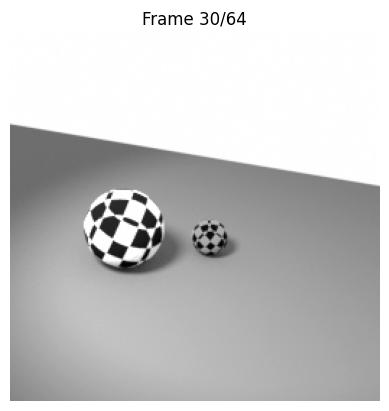

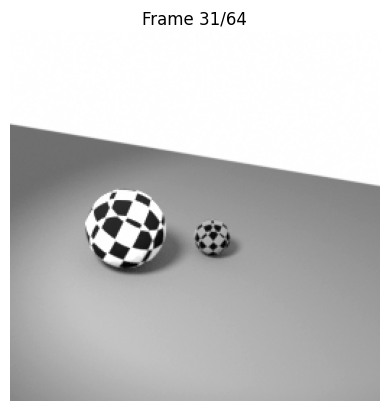

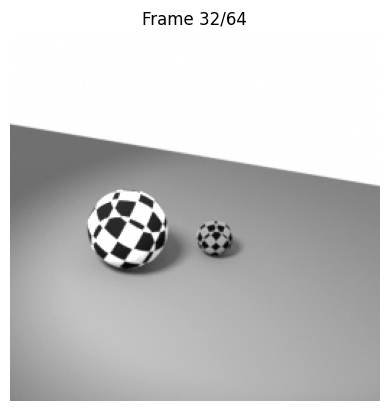

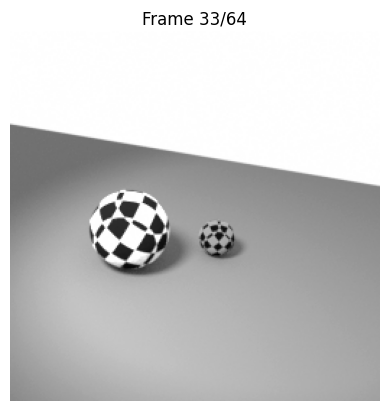

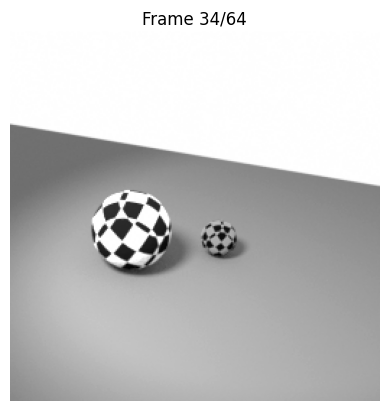

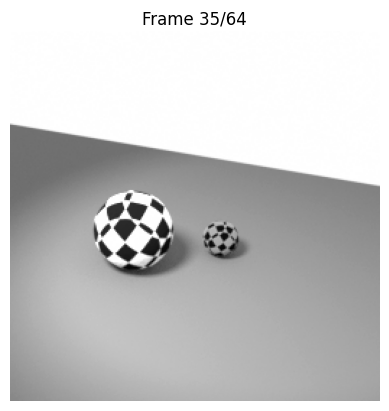

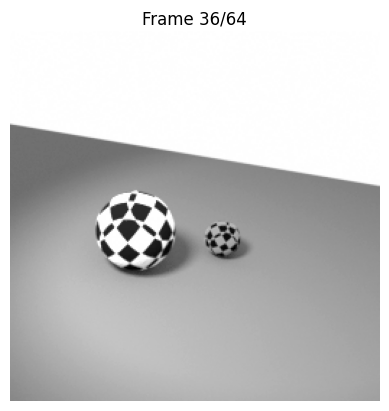

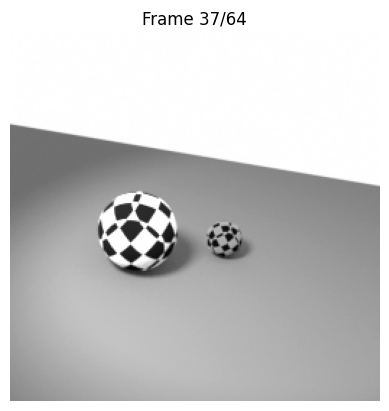

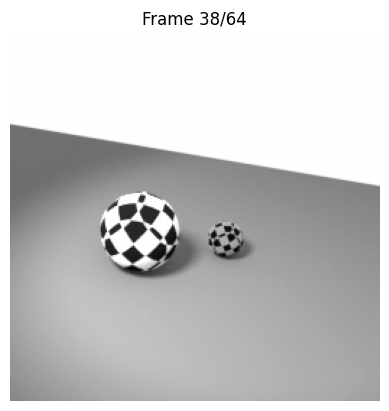

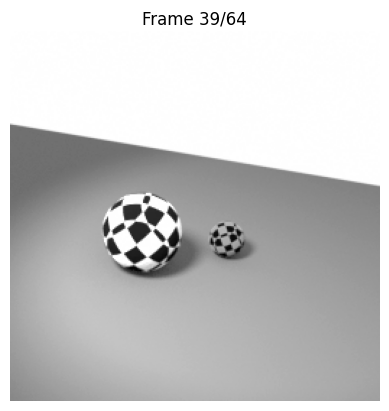

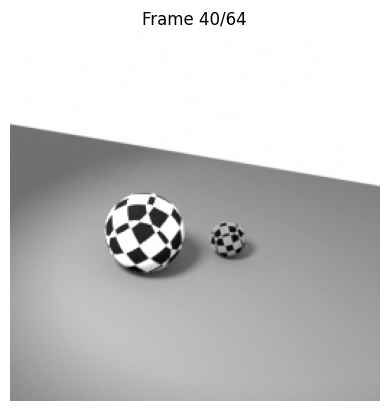

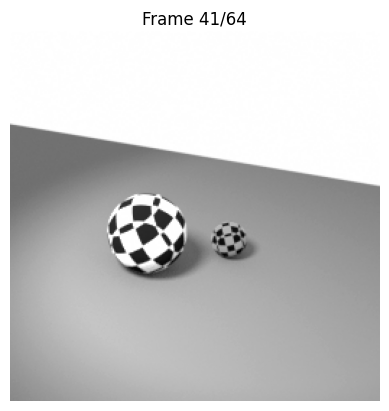

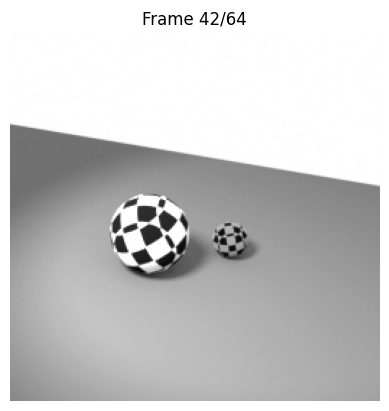

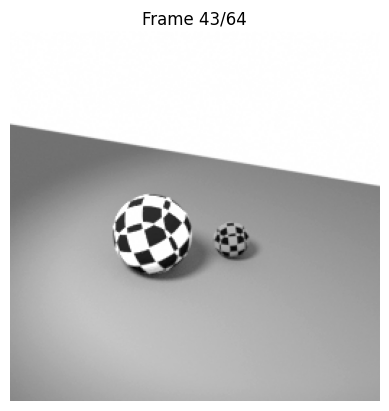

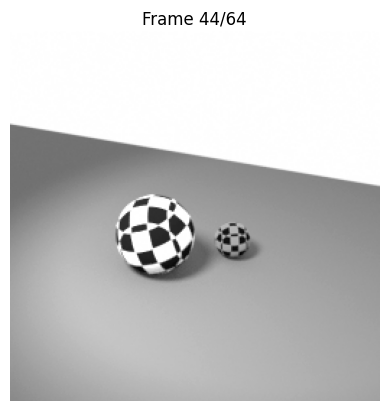

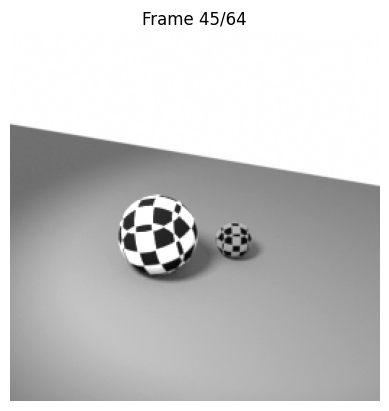

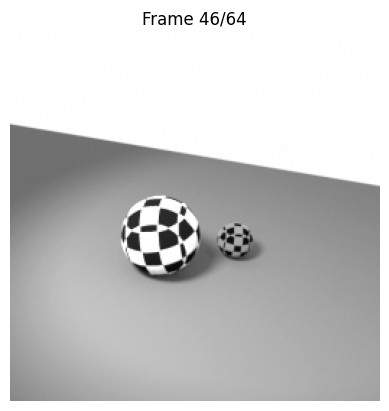

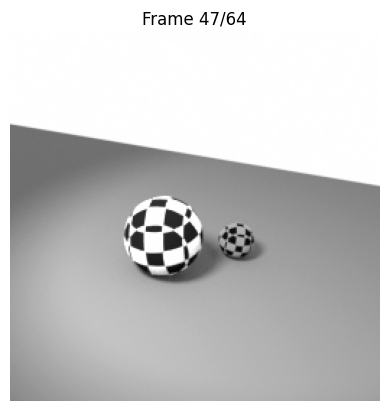

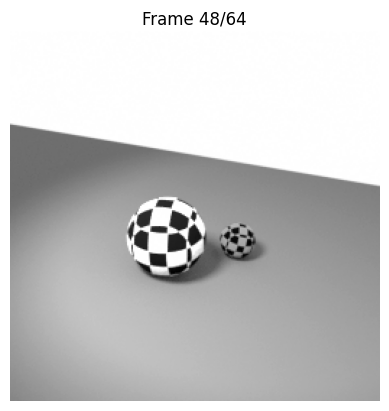

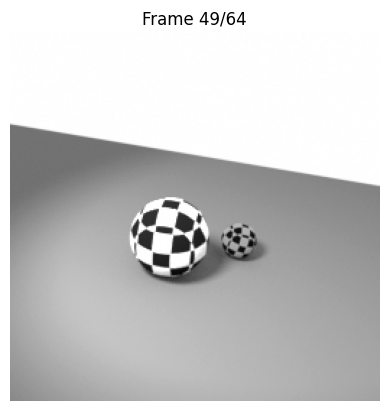

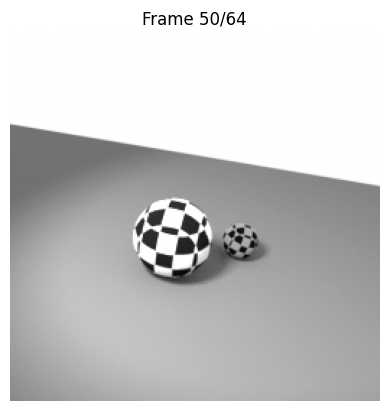

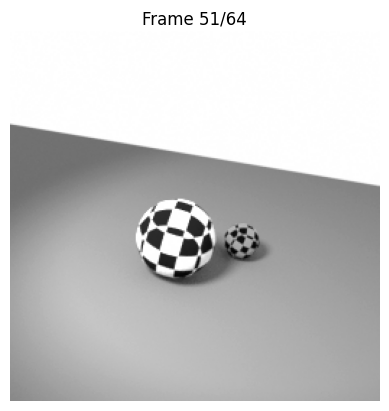

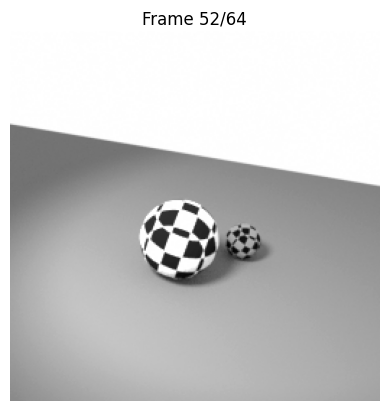

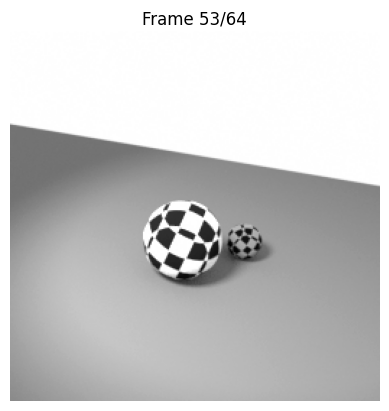

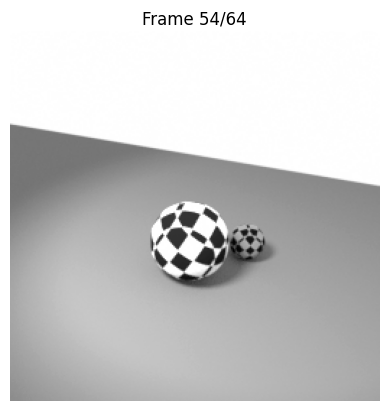

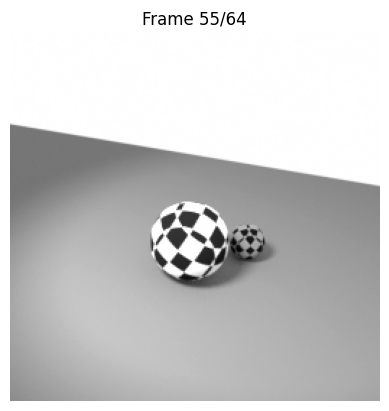

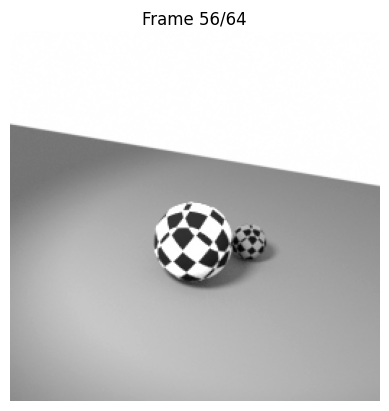

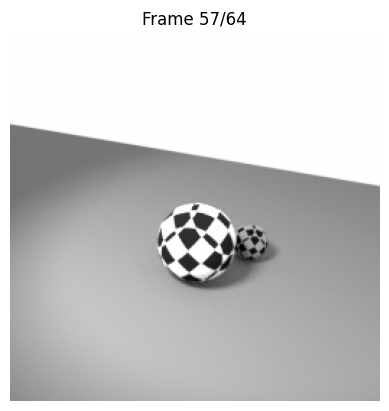

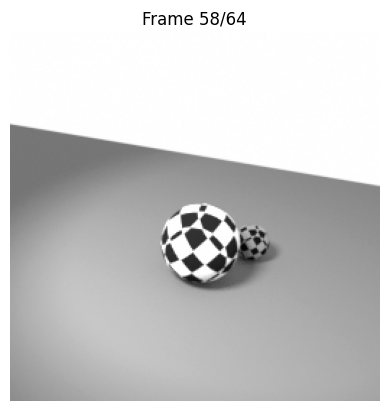

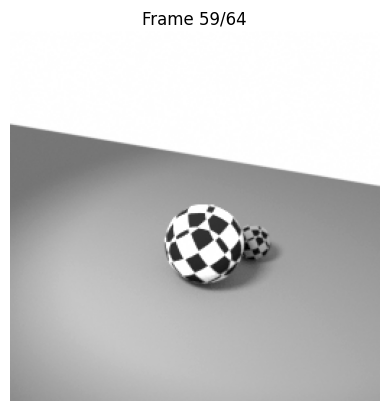

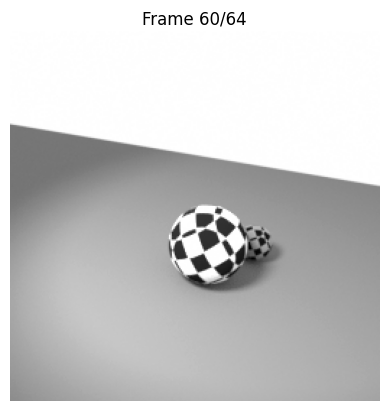

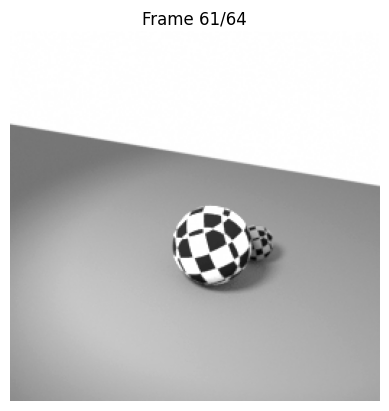

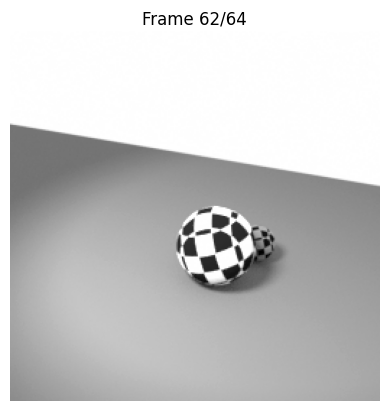

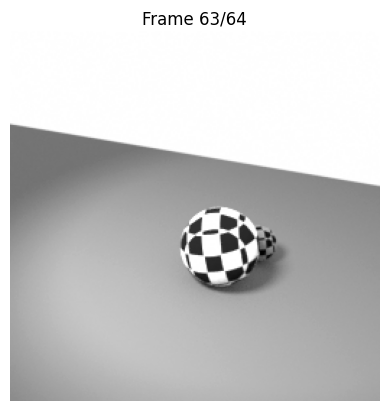

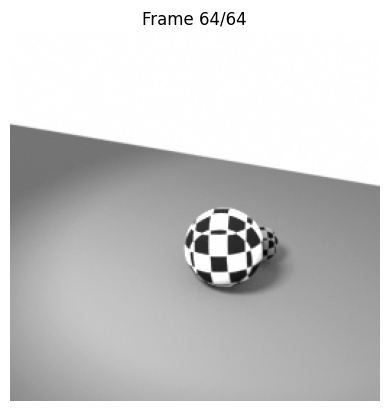

In [17]:
plt.figure()
for frame in range(num_frames):
    plt.imshow(image_sequence[frame], cmap="gray")
    plt.title(f"Frame {frame+1}/{num_frames}")
    plt.axis("off")
    plt.pause(0.1)
    plt.clf()

plt.close()

## Extracting Gradients

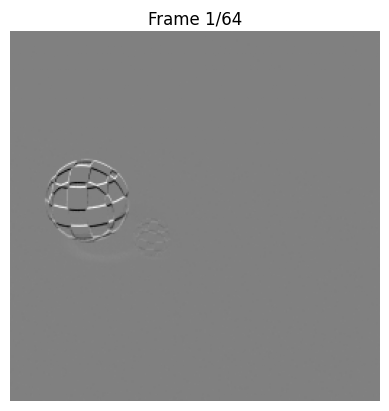

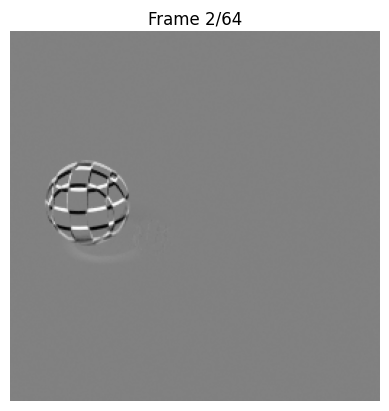

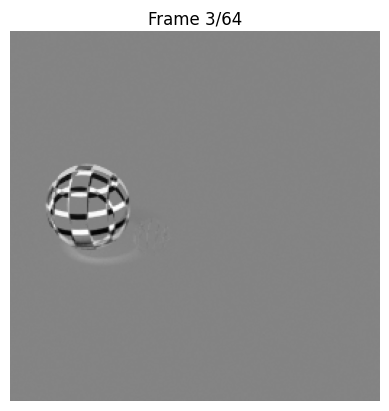

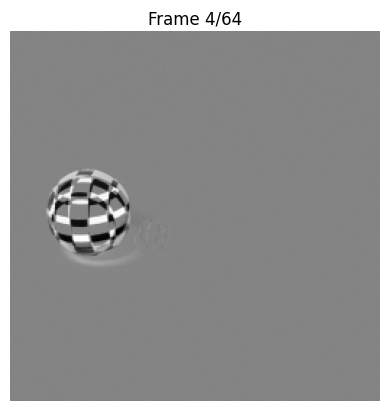

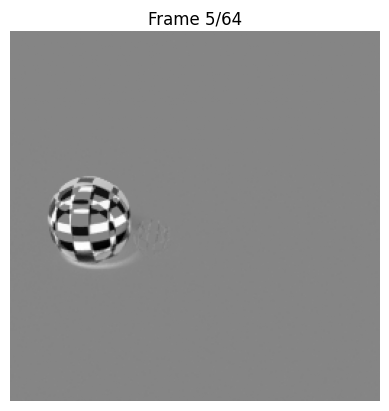

<Figure size 640x480 with 0 Axes>

In [36]:
gradient_shape = (255,255)

Vx_sequence = np.zeros((num_frames,*gradient_shape), dtype=np.float32)

Vy_sequence = np.zeros((num_frames,*gradient_shape), dtype=np.float32)

Vt_sequence = np.zeros((num_frames,*gradient_shape), dtype=np.float32)

for frame in range(num_frames-1):
    Vx_sequence[frame] = image_sequence[frame][1:,:-1]  - image_sequence[frame][0:-1,:-1]
    Vy_sequence[frame] = image_sequence[frame][:-1,1:]  - image_sequence[frame][:-1,0:-1]
    Vt_sequence[frame] = image_sequence[frame][:-1,:-1] - image_sequence[frame + 1][:-1,:-1]

for frame in range(5):
    plt.imshow(Vt_sequence[frame], cmap="gray")
    plt.title(f"Frame {frame+1}/{num_frames}")
    plt.axis("off")
    plt.pause(0.1)
    plt.clf()


## Simple Gradient filters

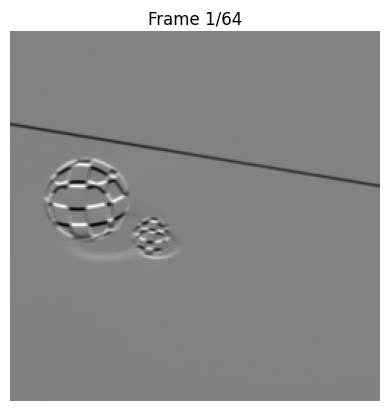

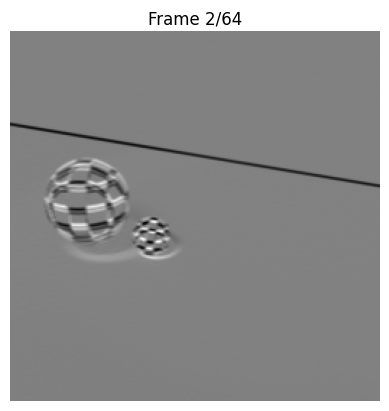

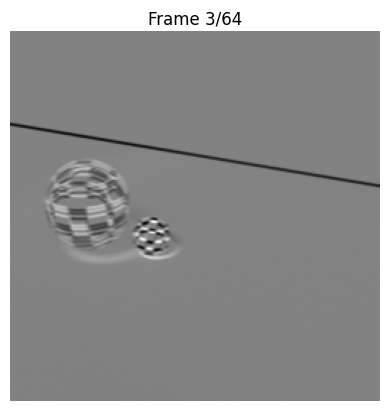

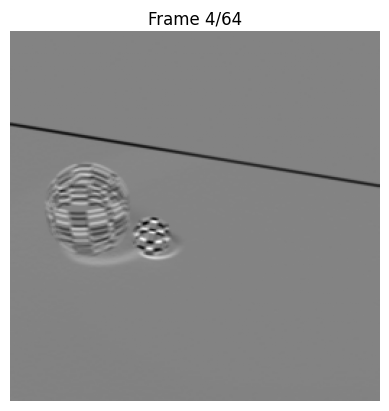

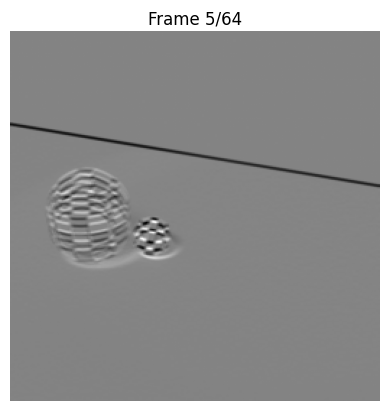

<Figure size 640x480 with 0 Axes>

In [49]:
prewitt = scipy.ndimage.prewitt(image_sequence,1)
sobel = scipy.ndimage.sobel(image_sequence)

for frame in range(5):
    plt.imshow(prewitt[frame], cmap="gray")
    plt.title(f"Frame {frame+1}/{num_frames}")
    plt.axis("off")
    plt.pause(0.1)
    plt.clf()

## Gaussian Filter

(61,)
(61,)


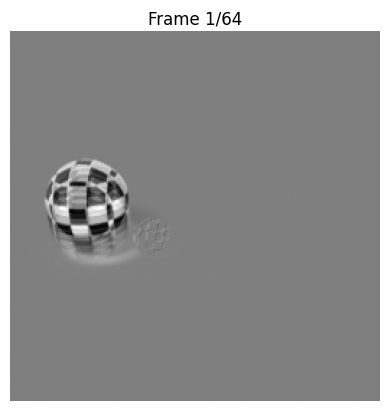

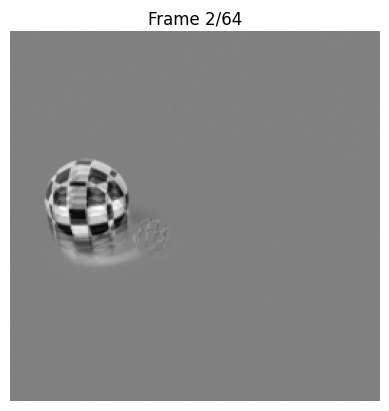

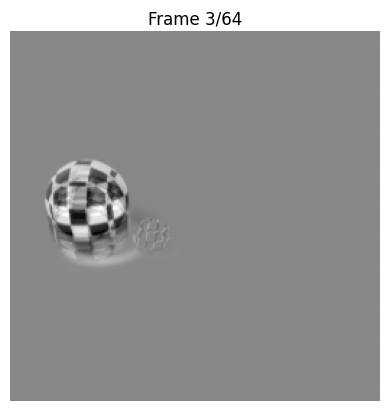

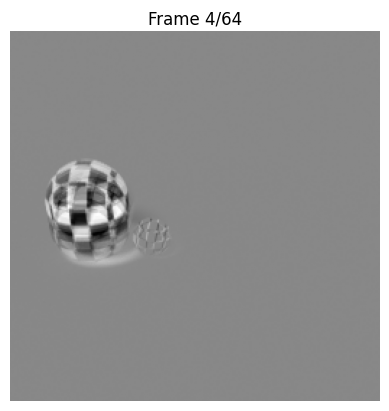

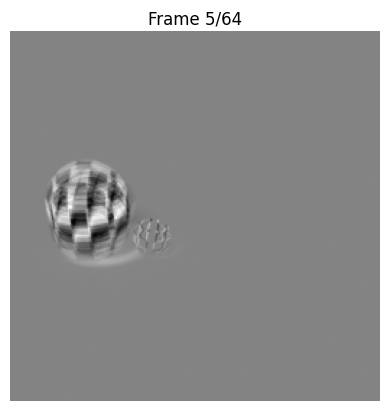

[2.11881925e-27 7.69459863e-23 1.02797736e-18 5.05227108e-15
 9.13472041e-12 6.07588285e-09 1.48671951e-06 1.33830226e-04
 4.43184841e-03 5.39909665e-02 2.41970725e-01 3.98942280e-01
 2.41970725e-01 5.39909665e-02 4.43184841e-03 1.33830226e-04
 1.48671951e-06 6.07588285e-09 9.13472041e-12 5.05227108e-15
 1.02797736e-18 7.69459863e-23 2.11881925e-27]


<Figure size 640x480 with 0 Axes>

In [61]:
#def Gauss(im,sigma):

def Gauss(x,sigma):
    return (1/(np.sqrt(2*np.pi*(sigma**2))))*np.exp(-(x**2)/(2*(sigma**2)))

def GaussArray(sigma,size):
    arr = np.arange(-sigma*size,sigma*size+1,1)
    G = Gauss(arr,sigma)
    return G

def dGauss(x,sigma):
    return (+x/(sigma**2))*(1/(np.sqrt(2*np.pi*(sigma**2))))*np.exp(-(x**2)/(2*(sigma**2)))

def dGaussArray(sigma,size):
    arr = np.arange(-sigma*size,sigma*size+1,1)
    G = dGauss(arr,sigma)
    return G

V_x = scipy.ndimage.convolve1d(image_sequence,dGaussArray(2,3),2)
V_y = scipy.ndimage.convolve1d(image_sequence,dGaussArray(2,3),1)
V_t = scipy.ndimage.convolve1d(image_sequence,dGaussArray(2,3),0)

print(np.shape(GaussArray(5,6)))
print(np.shape(GaussArray(5,6).T))

for frame in range(5):
    plt.imshow(V_t[frame], cmap="gray")
    plt.title(f"Frame {frame+1}/{num_frames}")
    plt.axis("off")
    plt.pause(0.1)
    plt.clf()
   

print(GaussArray(1,11))

## Lucas-Kanade

In [ ]:
## Single pixel solution

def LK_1pix(p,N):
    v_x = V_x[p[2],p[0]-N:p[0]+N,p[1]-N:p[1]+N].flatten()
    v_y = V_y[p[2],p[0]-N:p[0]+N,p[1]-N:p[1]+N].flatten()
    v_t = V_t[p[2],p[0]-N:p[0]+N,p[1]-N:p[1]+N].flatten()

    A = np.column_stack([v_x,v_y])
    b = -v_t.reshape(-1,1)

    return np.linalg.lstsq(A,b,rcond = None)[0]

print(LK_1pix([20,20,0],5))



[[0.03772485]
 [0.01439179]]


In [68]:
def LK():
    field = np.zeros([64,10,10,2])
    for t in range(0,63):
        for i in range(0,10):
            for j in range(0,10):
                xy = LK_1pix([10*i+5,10*j+5,t],5)
                field[t,i,j,0] = xy[0]
                field[t,i,j,1] = xy[1]
    return field

def LK2(x,y):
    return LK[0,x,y,:]

print(LK().shape)
print(LK()[0,:,:,:])

# Meshgrid 
x, y = np.meshgrid(np.linspace(-5, 5, 10),  
                   np.linspace(-5, 5, 10)) 
  
u, v = LK2(x,y)

# Plotting Vector Field with QUIVER 
plt.quiver(x, y, u, v, color='g') 
plt.title('Vector Field') 
  
# Setting x, y boundary limits 
plt.xlim(-7, 7) 
plt.ylim(-7, 7) 
  
# Show plot with grid 
plt.grid() 
plt.show() 

C:\Users\askha\AppData\Local\Temp\ipykernel_37484\186611274.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  field[t,i,j,0] = xy[0]
C:\Users\askha\AppData\Local\Temp\ipykernel_37484\186611274.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  field[t,i,j,1] = xy[1]


(64, 10, 10, 2)
[[[-2.16151793e-02  7.85254780e-03]
  [ 5.41930757e-02 -5.70847699e-03]
  [-5.93414111e-03 -3.82721052e-03]
  [-2.03175489e-02 -3.98868807e-02]
  [-2.10738610e-02 -4.19837907e-02]
  [ 6.25040522e-03 -3.25927697e-02]
  [-1.59743689e-02 -2.50658151e-02]
  [-8.10144376e-03 -4.71415035e-02]
  [ 1.16168419e-02 -1.01735070e-02]
  [-1.08696828e-02 -2.74368636e-02]]

 [[-3.32243033e-02 -2.36593988e-02]
  [-1.90323256e-02 -3.98641154e-02]
  [ 3.63035174e-03  5.59788896e-03]
  [ 2.50715576e-02  6.95490526e-05]
  [-2.35404372e-02 -2.43675895e-02]
  [-2.61331047e-03 -4.41907346e-02]
  [ 3.24157736e-04  5.54863922e-02]
  [ 1.06525589e-02 -1.86382253e-02]
  [-3.27906981e-02 -5.67452870e-02]
  [ 2.33875029e-02 -1.31750954e-02]]

 [[-1.16728004e-02 -2.78815944e-02]
  [-7.49076828e-02 -2.03174283e-03]
  [ 5.90493483e-03  7.91756660e-02]
  [-3.15759890e-03 -4.80647665e-03]
  [-1.75206549e-02 -9.96437483e-03]
  [ 6.95211515e-02  1.04718199e-02]
  [-4.83627152e-03  4.52764891e-03]
  [ 1.91

TypeError: 'function' object is not subscriptable

In [47]:
print(image_sequence.shape)

(64, 256, 256)
